In [1]:
import cmasher as cmr
from matplotlib import rcParams
import matplotlib.pyplot as plt
colors = cmr.take_cmap_colors('cmr.bubblegum', 6, cmap_range=(0.05, 0.95), return_fmt='hex')
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14
rcParams['mathtext.default'] = 'regular'
from matplotlib import colors as cr
import pandas as pd
import seaborn as sns
import numpy as np
from astropy.cosmology import Planck18_arXiv_v2 as Planck18
from astropy import units as u

import catgen
import sfh
import param_dists as pdf

In [2]:
n_sample = 10000000
n_downsample=100
path = '../alpha_1'
label = r'$\alpha=1$'
mets = np.logspace(np.log10(0.0001), np.log10(0.03), 30)
mets = mets[:-1]

In [3]:
cat = catgen.Catalog(dat_path=path,                     
                     sfr_model=sfh.mf_17,
                     met_grid=mets, 
                     kstar_1='14', 
                     kstar_2='14', 
                     SFstart=13700.0, 
                     SFduration=0.0)



/mnt/ceph/users/kbreivik/merger_catalog/cosmic-mergers/utils.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  dat = np.array(dat)


### build a catalog which contains mergers in a comoving volume of [Gpc$^3$]

In [4]:
mergers, norm_fac = cat.build_cat(n_sample=n_sample, n_downsample=n_downsample)

100%|██████████| 29/29 [00:03<00:00,  8.24it/s]


#### Check how the grid looks with the BBH formation efficience

Text(0, 0.5, 'BBH formation efficiency [M$_{\\odot}^{-1}$]')

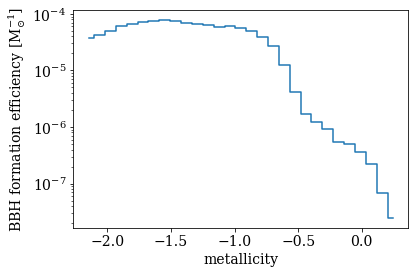

In [6]:
plt.plot(np.log10(mets/0.014), cat.n_BBH/cat.M_sim, drawstyle='steps-mid')
plt.yscale('log')
plt.xlabel('metallicity')
plt.ylabel('BBH formation efficiency [M$_{\odot}^{-1}$]')

Text(0, 0.5, 'N per metallicity grid')

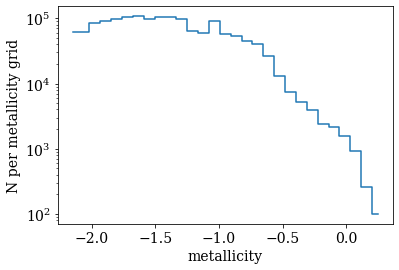

In [7]:
plt.plot(np.log10(mets/0.014), cat.n_BBH, drawstyle='steps-mid')
plt.yscale('log')
plt.xlabel('metallicity')
plt.ylabel('N per metallicity grid')

#### Build the pdf of the merger lookback time distribution

In [8]:
p_tlb = pdf.get_dN_dtlb_dV(np.array(mergers.t_merge, dtype=float))


#### generate a set of lookback times and redshifts to evaulate the pdf
##### note that everything is in units of a comoving volume!

In [9]:
z_max = 15
z = np.expm1(np.linspace(0, np.log1p(z_max), 1000))
tlb = Planck18.lookback_time(z).to(u.Myr).value

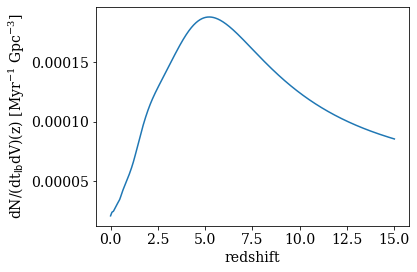

In [10]:
plt.plot(z, p_tlb(tlb))
plt.xlabel('redshift')
plt.ylabel(r'dN/(dt$_{\rm{lb}}$dV)(z) [Myr$^{-1}$ Gpc$^{-3}$]')
plt.tight_layout()

#### Now we can use the normalization factor which evaluates the average mass of BBH progenitors formed per unit solar mass from the merger catalog to get the rate!

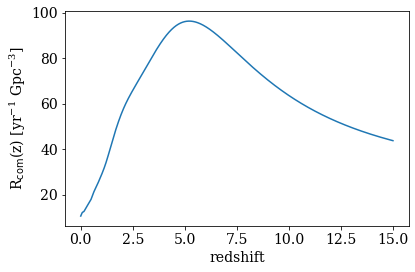

In [11]:
plt.plot(z, p_tlb(tlb) * norm_fac)
plt.xlabel('redshift')
plt.ylabel(r'R$_{\rm{com}}$(z) [yr$^{-1}$ Gpc$^{-3}$]')
plt.tight_layout()

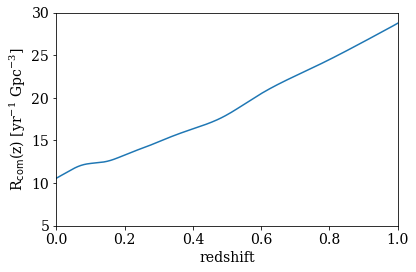

In [12]:
plt.plot(z, p_tlb(tlb) * norm_fac)
plt.xlabel('redshift')
plt.ylabel(r'R$_{\rm{com}}$(z) [yr$^{-1}$ Gpc$^{-3}$]')
plt.xlim(0, 1)
plt.ylim(5, 30)
plt.tight_layout()

#### We can also get the pdf of merger redshifts in the universe as measured from the detector frame

In [13]:
pz = pdf.get_pz(np.array(mergers.t_merge, dtype=float), z_max=15)

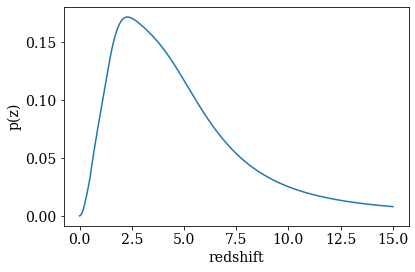

In [14]:
plt.plot(z, pz(z))
plt.xlabel('redshift')
plt.ylabel(r'p(z)')
plt.tight_layout()

#### And if we want to get the rate per mass per q

In [15]:
m1 = np.array(mergers.m1, dtype=float)
m2 = np.array(mergers.m2, dtype=float)
q = m2/m1
t = np.array(mergers.t_merge, dtype=float)

In [16]:
dN_dtlb_dlnm_dV = pdf.get_dN_dtlb_dlnm_dV(t_lb=t, m=m1)

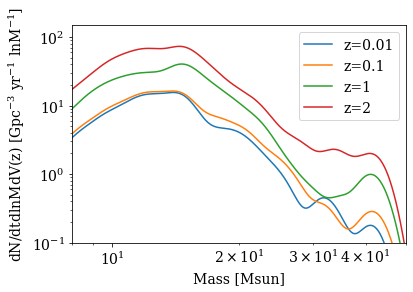

In [17]:
plt.plot(np.linspace(0.1, 50, len(tlb)), dN_dtlb_dlnm_dV(Planck18.lookback_time(0.01).to(u.Myr), 
                                                       np.linspace(0.1, 50, len(tlb))) * norm_fac, 
         label='z=0.01')
plt.plot(np.linspace(0.1, 50, len(tlb)), dN_dtlb_dlnm_dV(Planck18.lookback_time(0.1).to(u.Myr), 
                                                       np.linspace(0.1, 50, len(tlb))) * norm_fac, 
         label='z=0.1')
plt.plot(np.linspace(0.1, 50, len(tlb)), dN_dtlb_dlnm_dV(Planck18.lookback_time(1).to(u.Myr), 
                                                       np.linspace(0.1, 50, len(tlb))) * norm_fac, 
         label='z=1')
plt.plot(np.linspace(0.1, 50, len(tlb)), dN_dtlb_dlnm_dV(Planck18.lookback_time(2).to(u.Myr), 
                                                       np.linspace(0.1, 50, len(tlb))) * norm_fac, 
         label='z=2')

plt.ylabel('dN/dtdlnMdV(z) [Gpc$^{-3}$ yr$^{-1}$ lnM$^{-1}$]')
plt.xlabel('Mass [Msun]')
plt.legend()
plt.ylim(0.1, 150)
plt.xlim(8, 50)
plt.xscale('log')
plt.yscale('log')